In [32]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator

from scipy.cluster.hierarchy import linkage

In [18]:
clases = pd.read_csv('classes.csv')

In [19]:
clases_filtred = clases[clases['filename'].str.contains(r'^[a-zA-Z0-9_/\-.]+$', regex=True)]
clases_filtred['path'] = 'archive/' + clases_filtred['filename']

imagenes_random = clases_filtred['path'].sample(n=1000, random_state=42)

/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_2595/777794092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clases_filtred['path'] = 'archive/' + clases_filtred['filename']


Despues de varias pruebas y buscarle sentido a fitear el modelo con muchas imagenes, descubrí que no tiene sentido
ya que la idea es buscar los "centrides" de las imagenes y para eso solo se necesita una imagen a la vez por cada iteracion de entrenamiento.

In [20]:
images_random = clases_filtred['path'].sample(n=3)

In [28]:
images_random

38390    archive/Pop_Art/robert-silvers_not-detected-27...
52088    archive/Rococo/allan-ramsay_portrait-of-elizab...
27680    archive/Impressionism/micaela-eleutheriade_vas...
Name: path, dtype: object

In [21]:
images = []
for ima in  images_random:
    image = cv2.imread(ima)
    image_resized = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
    images.append(image_resized)

In [26]:
def optimal_cluster_number(data, max_clusters=7):
    
    silhouette_scores = []
    inertias = []
    min_k = 5
    k_range = range(min_k, max_clusters + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        inertias.append(kmeans.inertia_)
    
    # Normalizar inercias para la visualización
    inertias = np.array(inertias)
    inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Encontrar el número óptimo de clusters
    k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
    k_elbow = np.argmin(np.diff(inertias)) + min_k
    
    # Visualizar los métodos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Silhouette score
    ax1.plot(k_range, silhouette_scores)
    ax1.plot(k_silhouette, silhouette_scores[k_silhouette-min_k], 'ro')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Method')
    
    # Elbow method
    ax2.plot(k_range, inertias)
    ax2.plot(k_elbow, inertias[k_elbow-min_k], 'ro')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia (normalized)')
    ax2.set_title('Elbow Method')
    
    plt.tight_layout()
    plt.show()
    
    # Retornar el promedio de los dos métodos
    return int((k_silhouette + k_elbow) / 2)
    

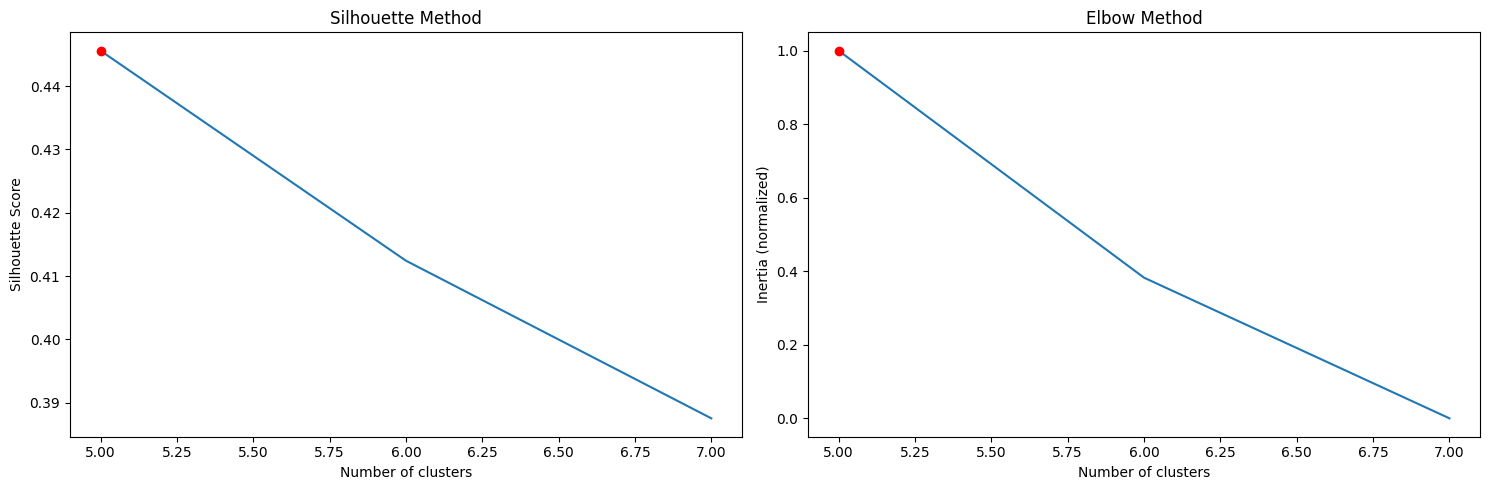

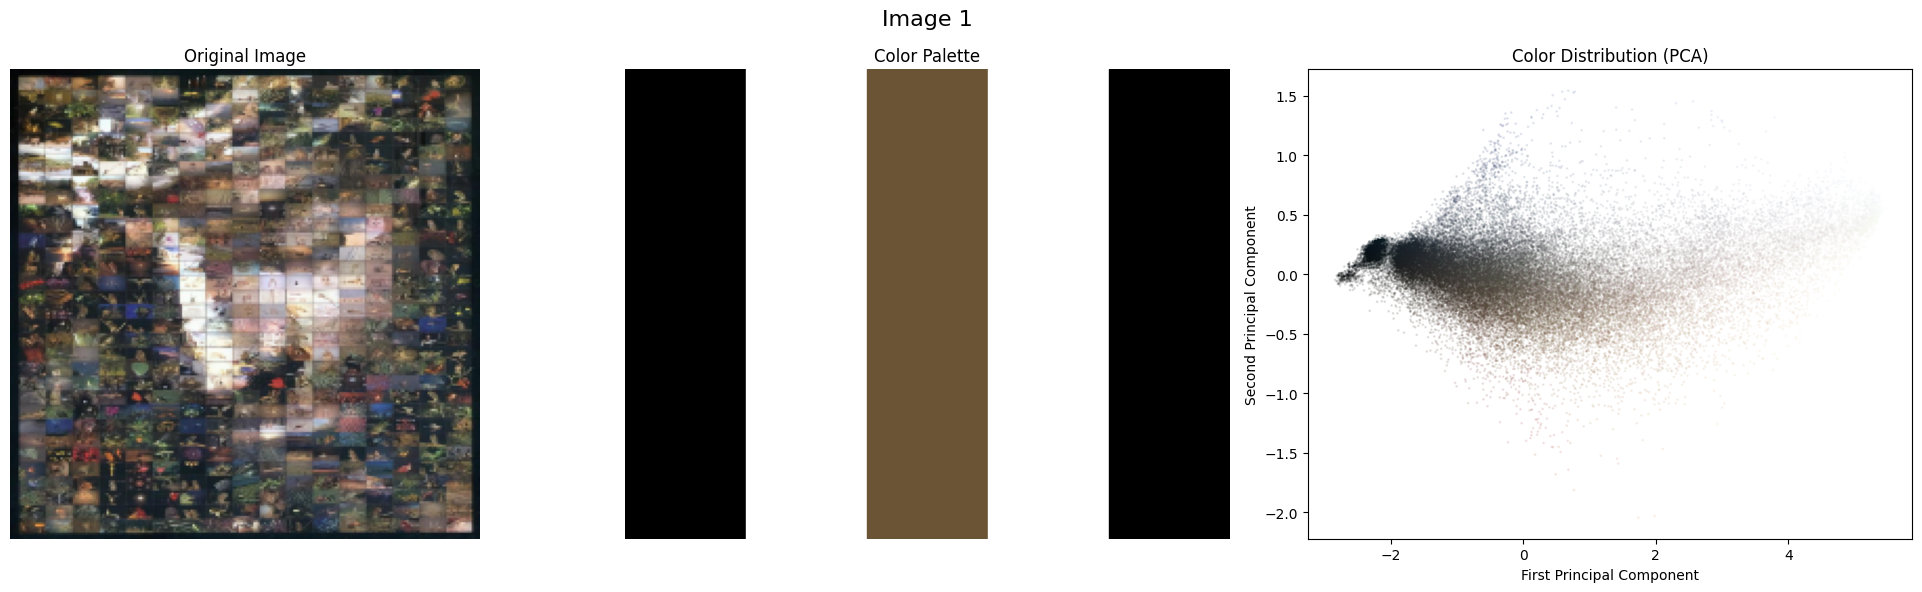

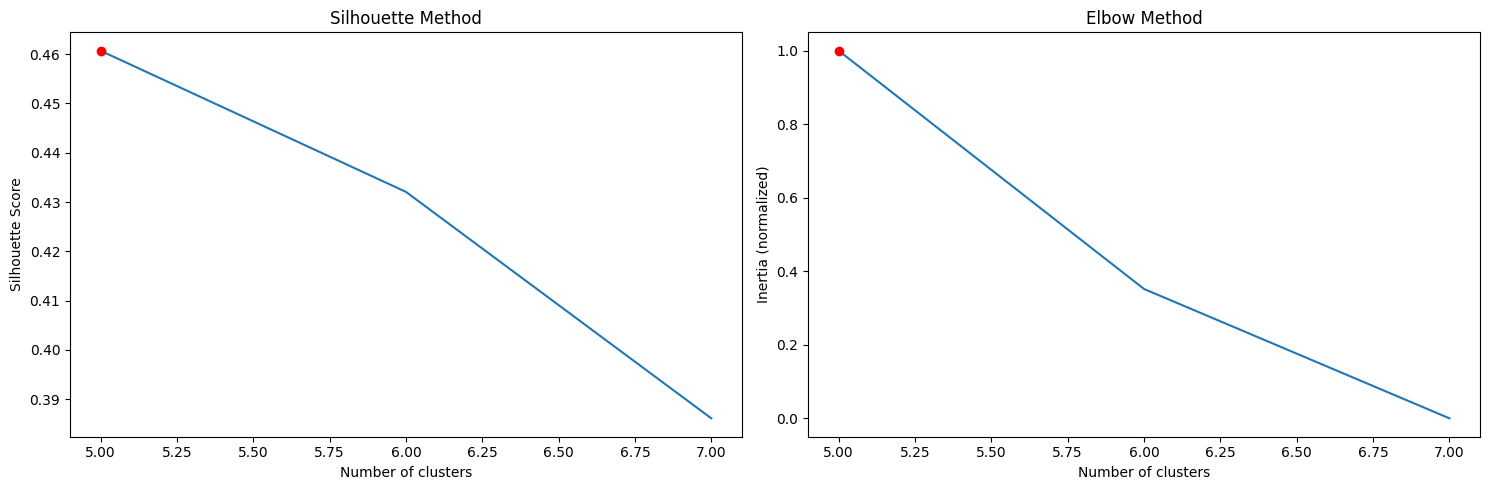

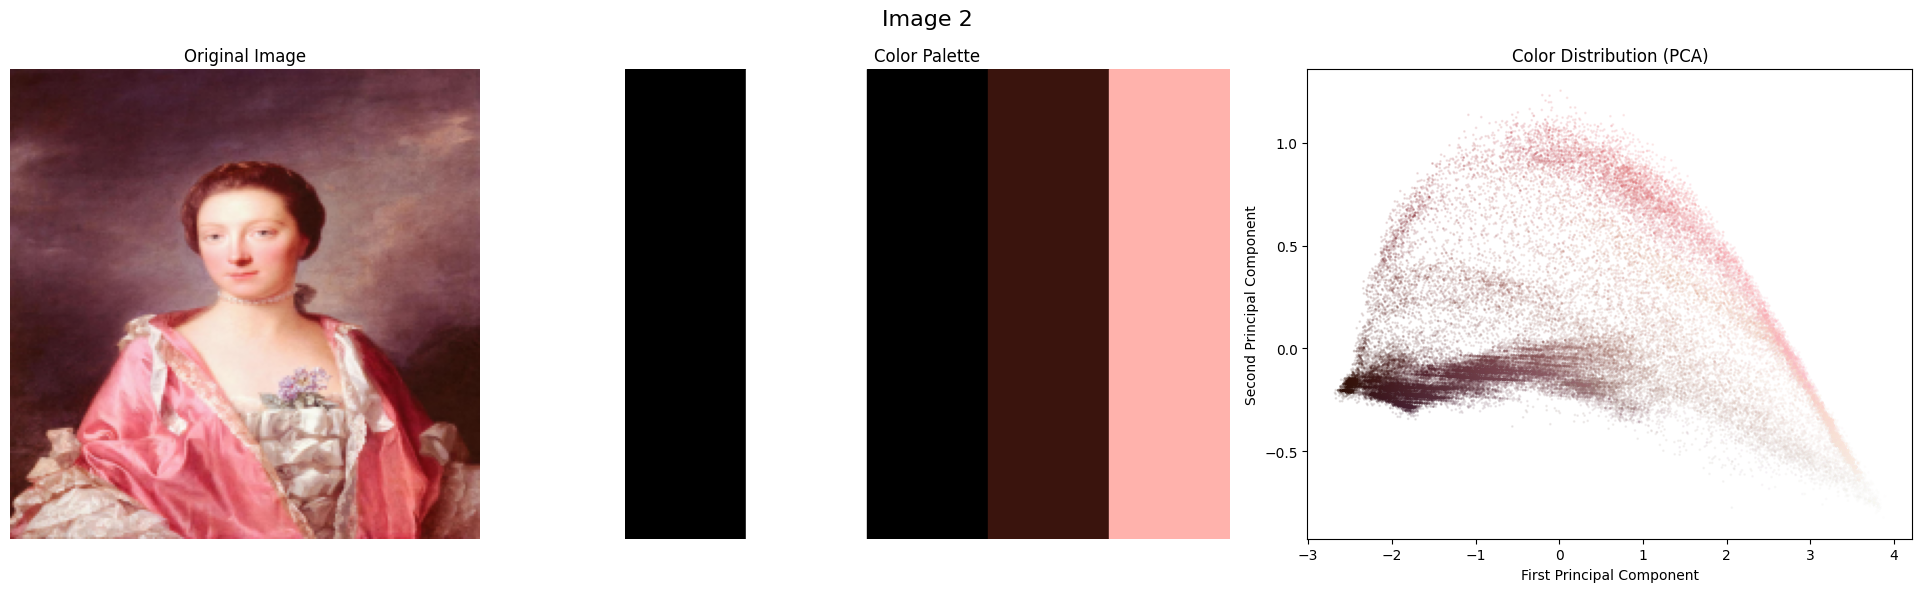

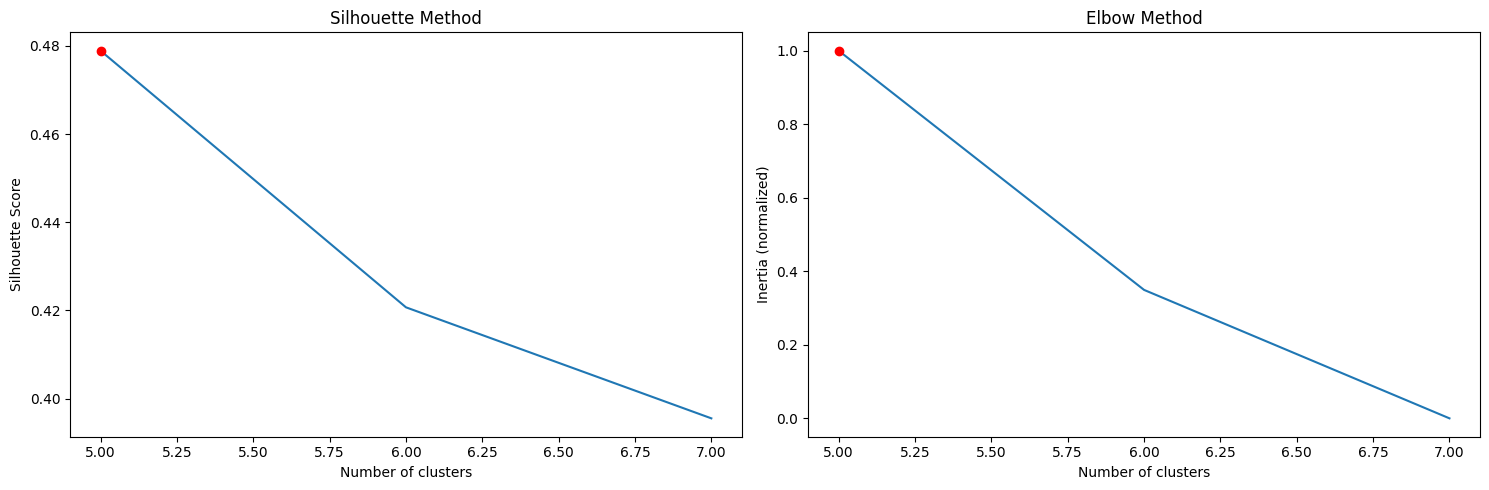

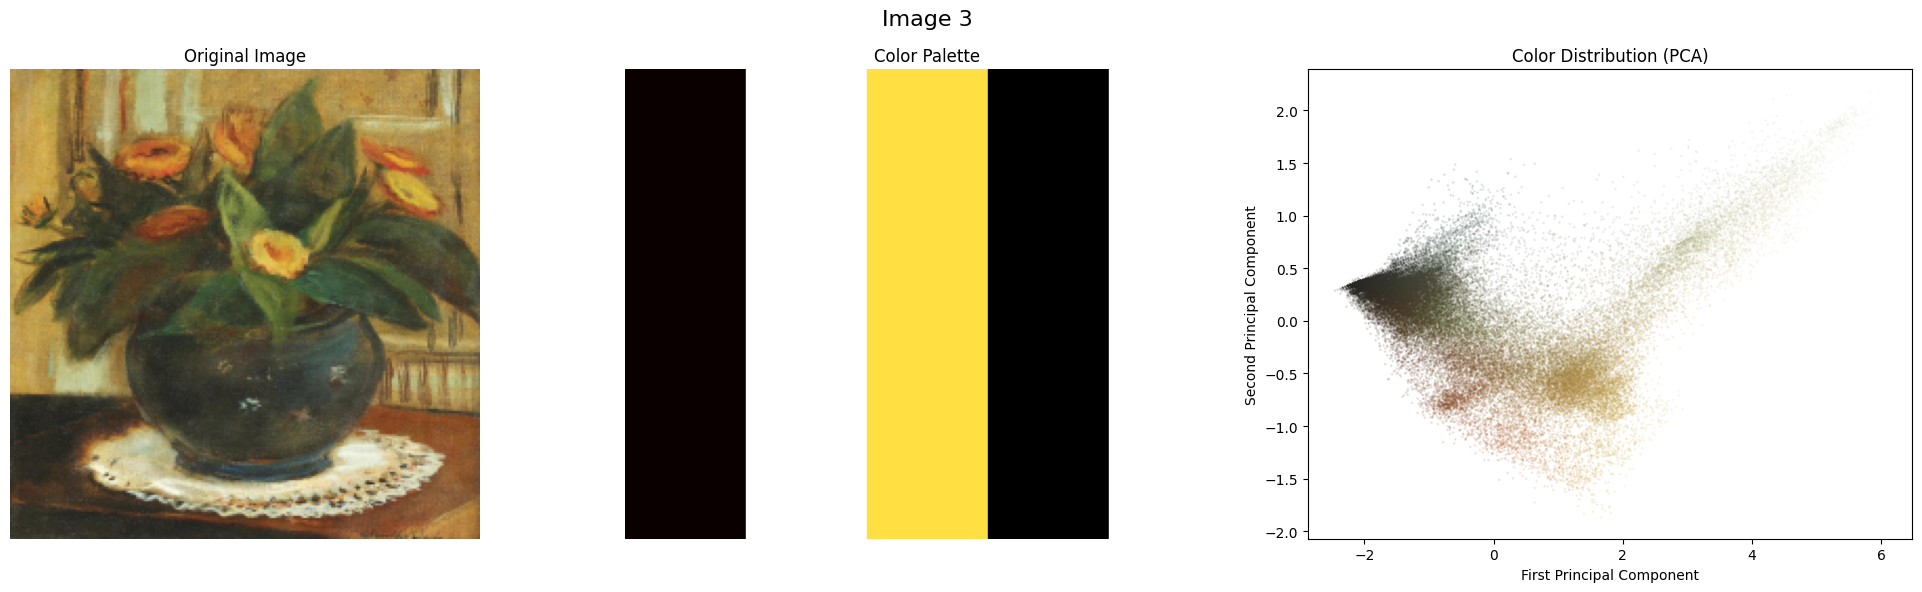

In [27]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    # no sirve
    n_colors = optimal_cluster_number(normalized_imag)


    kmeans = KMeans(n_clusters=n_colors, random_state=42)


    kmeans.fit(normalized_imag)

    colors = kmeans.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)


    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)
    
    #unque_colors = np.unique(colors, axis=0)
    #unque_colors = colors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')


    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title('Color Palette')

    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)



In [24]:
#fin

In [ ]:
def optimal_cluster_number(data, max_clusters=7):
    n_samples, n_features = data.shape
    
    # Calcular la matriz de enlace
    linkage_matrix = linkage(data, method='ward')
    
    # Calcular las distancias de enlace para diferentes números de clusters
    last = linkage_matrix[-max_clusters:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    
    # Calcular la aceleración de la curva
    acceleration = np.diff(last_rev, 2)
    acceleration_rev = acceleration[::-1]
    
    k = acceleration_rev.argmax() + 2  # El número óptimo de clusters
    
    # Visualizar el método del codo
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(idxs, last_rev)
    plt.plot(idxs[k-1], last_rev[k-1], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Linkage distance')
    plt.title('Elbow Method for Optimal k')
    
    # Visualizar la aceleración
    plt.subplot(122)
    plt.plot(idxs[:-2], acceleration_rev)
    plt.plot(idxs[k-2], acceleration_rev[k-2], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Acceleration of linkage distance')
    plt.title('Acceleration Method for Optimal k')
    
    plt.tight_layout()
    plt.show()
    
    return k


def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number(normalized_imag)
    print(f"Optimal number of clusters for {title}: {n_colors}")

    agglo = AgglomerativeClustering(n_clusters=n_colors)
    agglo.fit(normalized_imag)

    colors = []
    for i in range(n_colors):
        cluster_pixels = ima[agglo.labels_ == i]
        avg_color = np.mean(cluster_pixels, axis=0)
        colors.append(avg_color)

    
    colors = np.array(colors)
    colors = np.clip(colors, 0, 255).astype(int)

    # Aplicar PCA
    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)

    # Crear la visualización
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)

    # Mostrar la imagen original
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')

    # Mostrar la paleta de colores
    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title(f'Color Palette (k={n_colors})')

    # Visualizar la distribución de colores con PCA
    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

In [100]:
class ReadImages(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
       
    
    def transform(self, X):
        return cv2.imread(X)


In [114]:
class ImagePreprocessor(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # El preprocesamiento en sí se hace en el transform
        return self

    def transform(self, X, y=None):
        image_resized = cv2.resize(X, (224,224), interpolation=cv2.INTER_AREA)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        ima = image_rgb.reshape(-1, 3)
        scaler = StandardScaler()
        normalized_imag = scaler.fit_transform(ima)
        return [normalized_imag, image_rgb, ima]

In [151]:
class ModelEvaluation(BaseEstimator):
    def __init__(self, model = 'kmeans'):
        self.model = model
        pass

    def optimal_cluster_numbe_aglo(self, data, max_clusters=7):

        self.plot_list = []

        linkage_matrix = linkage(data, method='ward')
    
        # Calcular las distancias de enlace para diferentes números de clusters
        last = linkage_matrix[-max_clusters:, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        
        # Calcular la aceleración de la curva
        acceleration = np.diff(last_rev, 2)
        acceleration_rev = acceleration[::-1]
        
        k = acceleration_rev.argmax() + 2  # El número óptimo de clusters


        self.plot_list.append(idxs)
        self.plot_list.append(last_rev)
        self.plot_list.append(acceleration_rev)
        self.plot_list.append(k)

        return k
    
    

    def optimal_cluster_number_km(self, data, max_clusters=7):


        self.plot_list = []
    
        silhouette_scores = []
        inertias = []
        min_k = 5
        k_range = range(min_k, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
            inertias.append(kmeans.inertia_)
        
        # Normalizar inercias para la visualización
        inertias = np.array(inertias)
        inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
        
        # Encontrar el número óptimo de clusters
        k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
        k_elbow = np.argmin(np.diff(inertias)) + min_k

        self.plot_list.append(k_range)
        self.plot_list.append(silhouette_scores)
        self.plot_list.append(k_silhouette)
        self.plot_list.append(min_k)
        self.plot_list.append(inertias)
        self.plot_list.append(k_elbow)


        # Retornar el promedio de los dos métodos
        return int((k_silhouette + k_elbow) / 2)
    
    
    def fit(self, X, y=None):

        normalized_imag, image_rgb, ima  = X

        if self.model == 'aglo':
            n_colors = self.optimal_cluster_numbe_aglo(normalized_imag)
            agglo = AgglomerativeClustering(n_clusters=n_colors)
            agglo.fit(normalized_imag)

            colors = []
            for i in range(n_colors):
                cluster_pixels = ima[agglo.labels_ == i]
                avg_color = np.mean(cluster_pixels, axis=0)
                colors.append(avg_color)
    
            colors = np.array(colors)
            self.colors = np.clip(colors, 0, 255).astype(int)

            #self.colors = [np.mean(ima[agglo.labels_ == i], axis=0) for i in range(n_colors)]

        else:
            n_colors = self.optimal_cluster_number_km(normalized_imag)

            kmeans = KMeans(n_clusters=n_colors, random_state=42)
            kmeans.fit(normalized_imag)

            colors = kmeans.cluster_centers_
            self.colors = np.clip(np.array(colors) * 255, 0, 255).astype(int)

        return self


    def transform(self, X):

        normalized_img, image_rgb, ima = X  

        # Aplicar PCA
        pca = PCA(n_components=2)
        pixels_2d = pca.fit_transform(normalized_img)

        if self.model == 'aglo':
            self.plot_ag()
        else:
            self.plot_km()

        # Crear la visualización
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        #fig.suptitle(title, fontsize=16)

        # Mostrar la imagen original
        ax1.imshow(image_rgb)
        ax1.axis('off')
        ax1.set_title('Original Image')

        # Mostrar la paleta de colores
        for i, color in enumerate(self.colors):
            ax2.axvspan(i, i+1, color=color/255)
        ax2.set_xlim(0, len(self.colors))
        ax2.axis('off')
        ax2.set_title(f'Color Palette (k={self.colors})')

        # Visualizar la distribución de colores con PCA
        ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
        ax3.set_title('Color Distribution (PCA)')
        ax3.set_xlabel('First Principal Component')
        ax3.set_ylabel('Second Principal Component')

        plt.tight_layout()
        plt.show()



    def plot_ag(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[0][self.plot_list[3]-1], self.plot_list[1][self.plot_list[3]-1], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Linkage distance')
        ax1.set_title('Elbow Method for Optimal k')
        
        # Visualizar la aceleración

        ax2.plot(self.plot_list[0][:-2], self.plot_list[2])
        ax2.plot(self.plot_list[0][self.plot_list[3]-2], self.plot_list[2][self.plot_list[3]-2], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Acceleration of linkage distance')
        ax2.set_title('Acceleration Method for Optimal k')
                
        plt.tight_layout()
        plt.show()

    def plot_km(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Silhouette score
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[2], self.plot_list[1][self.plot_list[2]-self.plot_list[3]], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Method')
        
        # Elbow method
        ax2.plot(self.plot_list[0], self.plot_list[4])
        ax2.plot(self.plot_list[5], self.plot_list[4][self.plot_list[5]-self.plot_list[3]], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Inertia (normalized)')
        ax2.set_title('Elbow Method')
        
        plt.tight_layout()
        plt.show()

        
    


In [148]:
pipeline = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation(model='kmeans'))
                     ])

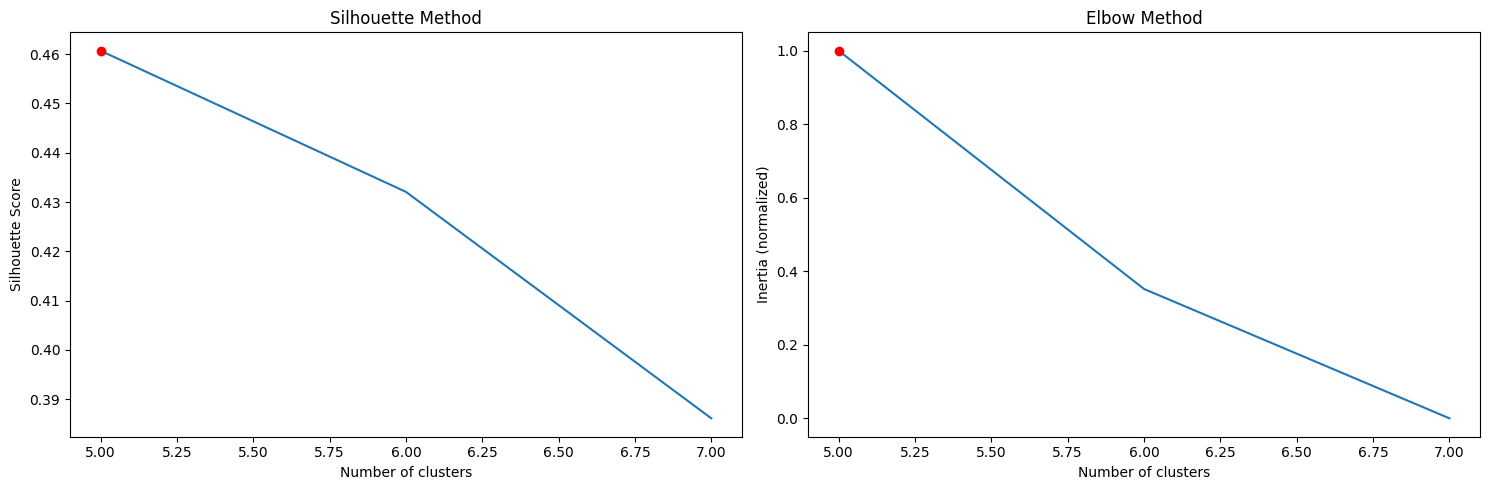

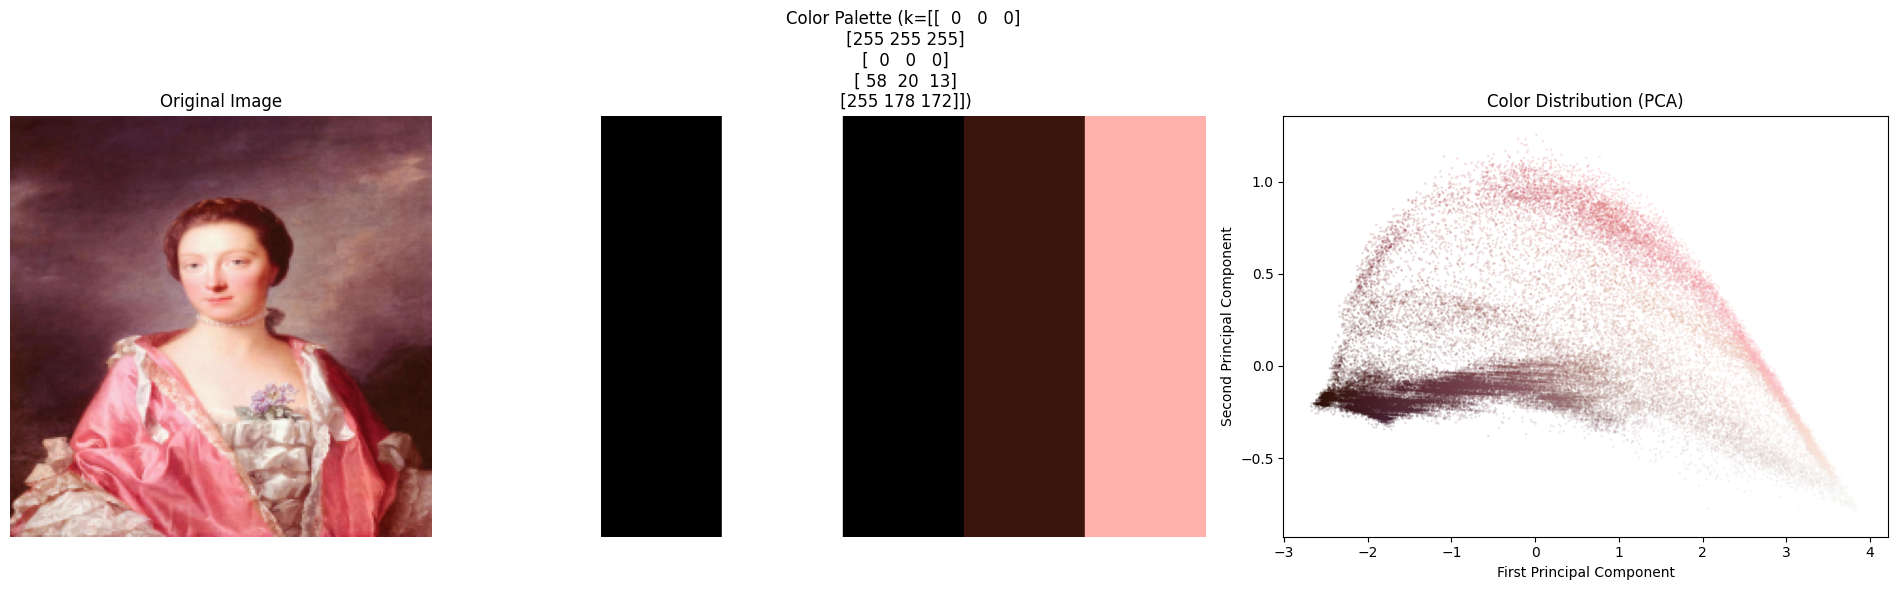

In [140]:
pipeline.fit_transform(images_random.values[1])

In [152]:
pipeline = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation(model='aglo'))
                     ])

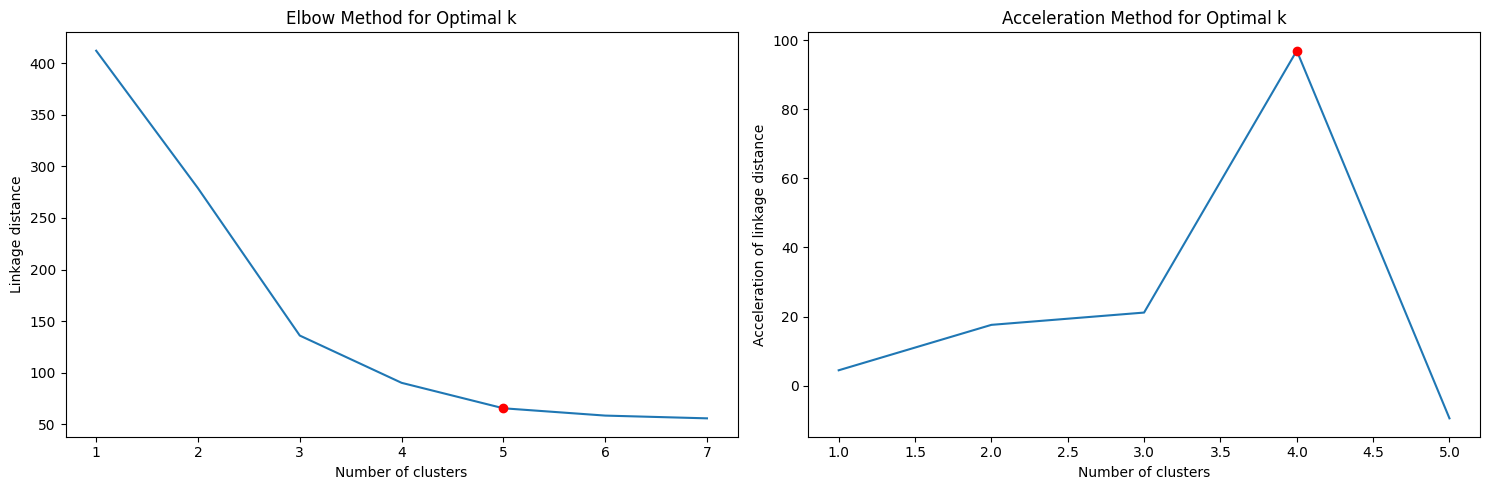

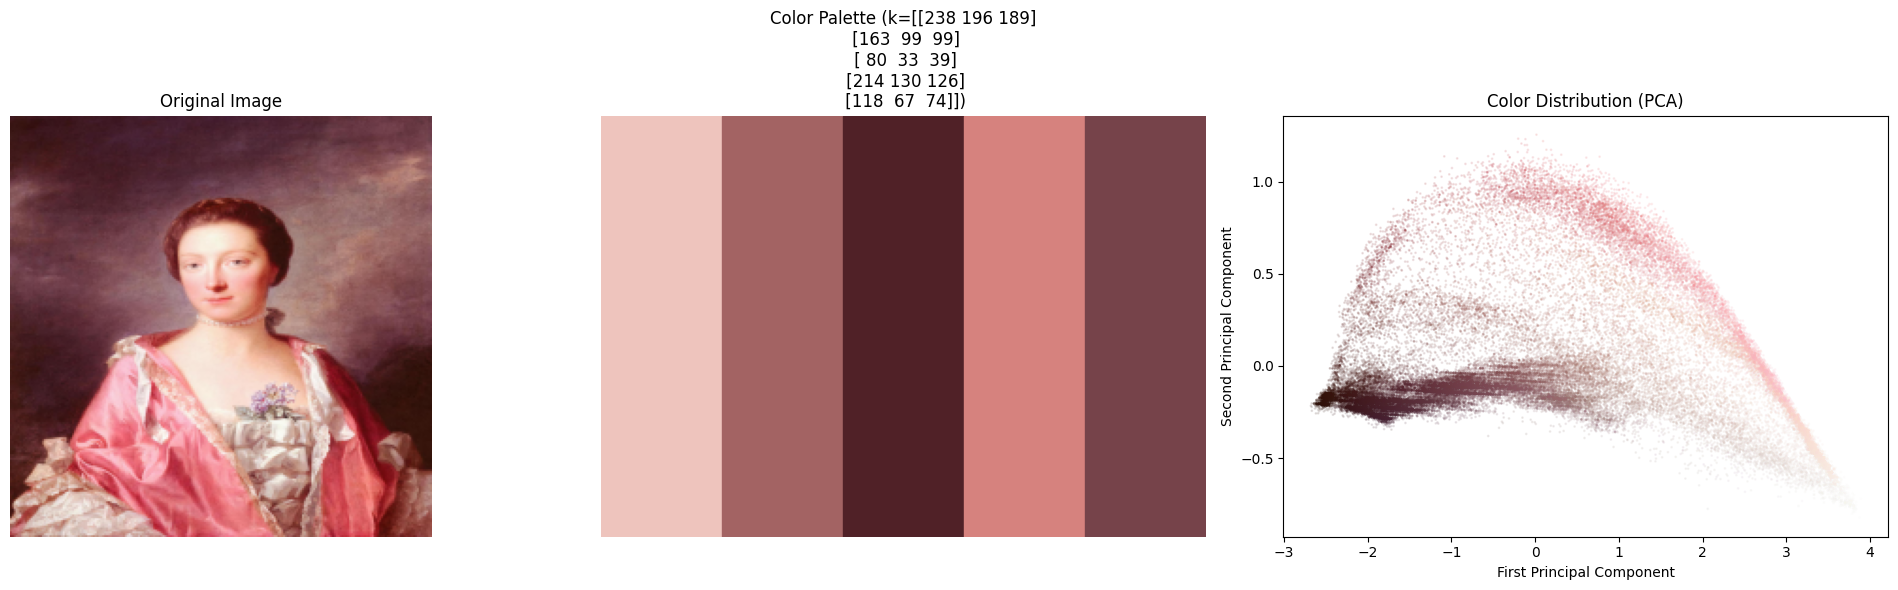

In [153]:
pipeline.fit_transform(images_random.values[1])